# ECG Feature Extraction (Final Version)
---
This notebook performs feature extraction for multilead ECG signals using prior preprocessing.

### What we have:
- Input data is already resampled to 250 Hz
- Bandpass filtering has been applied
- Signals are in NumPy array format `[samples, timepoints, leads]`

### What this notebook will do:
1. Load the preprocessed signals
2. Apply SAK segmentation (P-QRS-T)
3. Extract key morphological features per lead
4. Visualize signal + segmentation masks
5. Save `all_features.csv`


In [1]:

import pickle
import numpy as np
import pandas as pd
import torch
import sak
import matplotlib.pyplot as plt
from typing import List
from pathlib import Path

# Load pretrained SAK models
model_dir = "data/modelos"  # Change this to your actual path
models = [torch.load(f"{model_dir}/model.{i+1}") for i in range(5)]

print("Loaded SAK models.")


C:\Users\Usuario\AppData\Local\Temp\ipykernel_15920\2972073095.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  models = [torch.load(f"{model_dir}/model.{i+1}") for i in

Loaded SAK models.


In [2]:

# Load the preprocessed signal array
with open("data/processed_data_big_dataset/df_signals_preprocessed.pkl", "rb") as f:
    df_signals = pickle.load(f)

print(f"Loaded df_signals with shape: {df_signals.shape}")


Loaded df_signals with shape: (29153, 18)


### Step 1: Load Preprocessed ECGs

In [3]:

# load preprocessed_ecgs.pkl from disk 

with open("data/processed_data_big_dataset/preprocessed_ecgs.pkl", "rb") as f:
    ecg_signals_all = pickle.load(f)


### Step 2: Define segmentation function from ECGExample

In [7]:

from sak.signal.interpolate import interp1d
import skimage.util
import math
import scipy.signal as sp

def predict_ecg(ecg, fs=250, model=None, window_size=2048, stride=256, threshold_ensemble=0.5,
                thr_dice=0.9, ptg_voting=0.5, batch_size=16):
    
    if ecg.shape[0] < 50:
        raise ValueError(f"Signal too short for segmentation: {ecg.shape}")
    
    ecg = np.copy(ecg)
    if ecg.ndim == 2 and ecg.shape[0] < ecg.shape[1]:
        ecg = ecg.T
    ecg = ecg[:, :12]  # Only first 12 leads
    
    # Pad if needed
    N = ecg.shape[0]
    if N < window_size:
        pad = math.ceil(N / window_size) * window_size - N
        ecg = np.pad(ecg, ((0, pad), (0, 0)), mode='edge')
    if (ecg.shape[0] - window_size) % stride != 0:
        pad = math.ceil((ecg.shape[0] - window_size) / stride) * stride - (ecg.shape[0] % window_size)
        ecg = np.pad(ecg, ((0, pad), (0, 0)), mode='edge')

    # Windowing
    windowed = skimage.util.view_as_windows(ecg, (window_size, ecg.shape[1]), step=(stride, 1))
    windowed = windowed[:, 0, :, :]  # Remove the singleton dimension (N_windows, 2048, 12)

    windowed = np.swapaxes(windowed, 1, 2)

    mask = np.zeros((windowed.shape[0], 3, window_size), dtype=int)
    device = "cuda" if torch.cuda.is_available() else "cpu"

    with torch.no_grad():
        for m in model:
            m = m.to(device)
            for i in range(0, windowed.shape[0], batch_size):
                inputs = {"x": torch.tensor(windowed[i:i+batch_size]).float().to(device)}
                outputs = m(inputs)["sigmoid"].cpu().numpy()
                mask[i:i+batch_size] += outputs > thr_dice
        mask = mask >= len(model) * threshold_ensemble

    # Reconstruct full mask
    full_mask = np.zeros((3, ecg.shape[0]))
    counter = np.zeros(ecg.shape[0])
    for i in range(0, mask.shape[0]):
        start = i * stride
        full_mask[:, start:start+window_size] += mask[i]
        counter[start:start+window_size] += 1
    full_mask = (full_mask / counter) > ptg_voting
    full_mask = full_mask[:, :N]

    if full_mask.ndim == 3 and full_mask.shape[-1] == 1:
        full_mask = full_mask.squeeze(-1)

    return full_mask
    

### Step 3: Visualize Segmentation

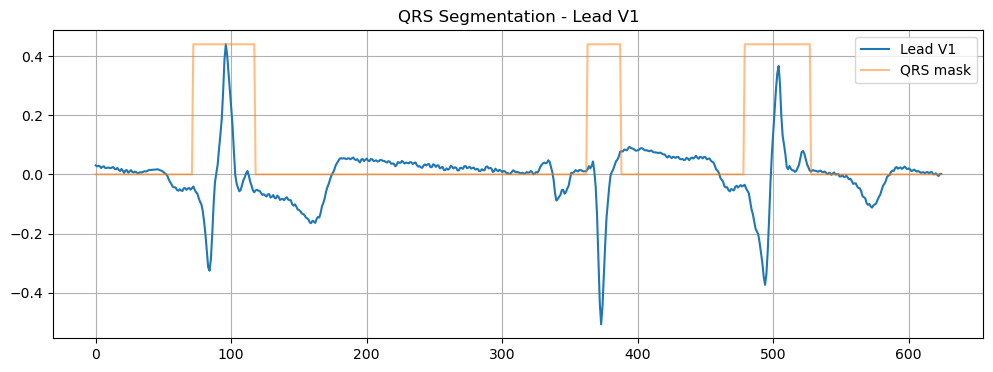

In [8]:

# Visualize segmentation for Lead V1 only
# Assumes: ecg_signals_all and models are loaded

# Select the first ECG sample
signal = ecg_signals_all[0]  # shape: (625, 12)

# Extract Lead V1 (column 6)
lead_v1 = signal[:, 6][:, np.newaxis]  # shape: (625, 1)

# Run SAK segmentation on the single lead
mask = predict_ecg(lead_v1, model=models)

# Plot signal and QRS mask overlay
plt.figure(figsize=(12, 4))
plt.plot(lead_v1, label='Lead V1')
plt.plot(mask[1] * np.max(lead_v1), label='QRS mask', alpha=0.5)
plt.title("QRS Segmentation - Lead V1")
plt.legend()
plt.grid(True)
plt.show()


### Step 4: Extract Morphological Features

In [12]:

def extract_morph_features(signal, mask, fs=250):
    features = {}
    transition_found = False
    precordial_index = -1

    for i, lead in enumerate(["I","II","III","AVR","AVL","AVF","V1","V2","V3","V4","V5","V6"]):
        lead_signal = signal[:, 0] if signal.ndim == 2 else signal

        # Catch completely empty signals or masks
        if lead_signal.shape[0] < 10 or mask.shape[0] != 3 or mask.shape[1] != lead_signal.shape[0]:
            raise ValueError(f"Signal or mask malformed for lead {lead}: signal shape {lead_signal.shape}, mask shape {mask.shape}")

        r_peak = np.max(lead_signal)
        s_trough = np.min(lead_signal)
        r_s_ratio = r_peak / abs(s_trough) if s_trough != 0 else 0

        qrs_indices = np.where(mask[1])[0]
        qrs_dur = (qrs_indices[-1] - qrs_indices[0]) / fs * 1000 if len(qrs_indices) > 1 else 0

        features[f"r_amp"] = r_peak
        features[f"s_amp"] = s_trough
        features[f"r_s_ratio"] = r_s_ratio
        features[f"qrs_dur"] = qrs_dur

        if lead.startswith("V") and not transition_found:
            if r_peak > abs(s_trough):
                precordial_index = int(lead[1])
                transition_found = True

        t_indices = np.where(mask[2])[0]
        if len(t_indices) > 3:
            t_mean = np.mean(lead_signal[t_indices])
            polarity = 1 if t_mean > 0.02 else (-1 if t_mean < -0.02 else 0)
        else:
            polarity = 0

        features[f"t_polarity"] = polarity

    features["precordial_transition"] = precordial_index
    return features



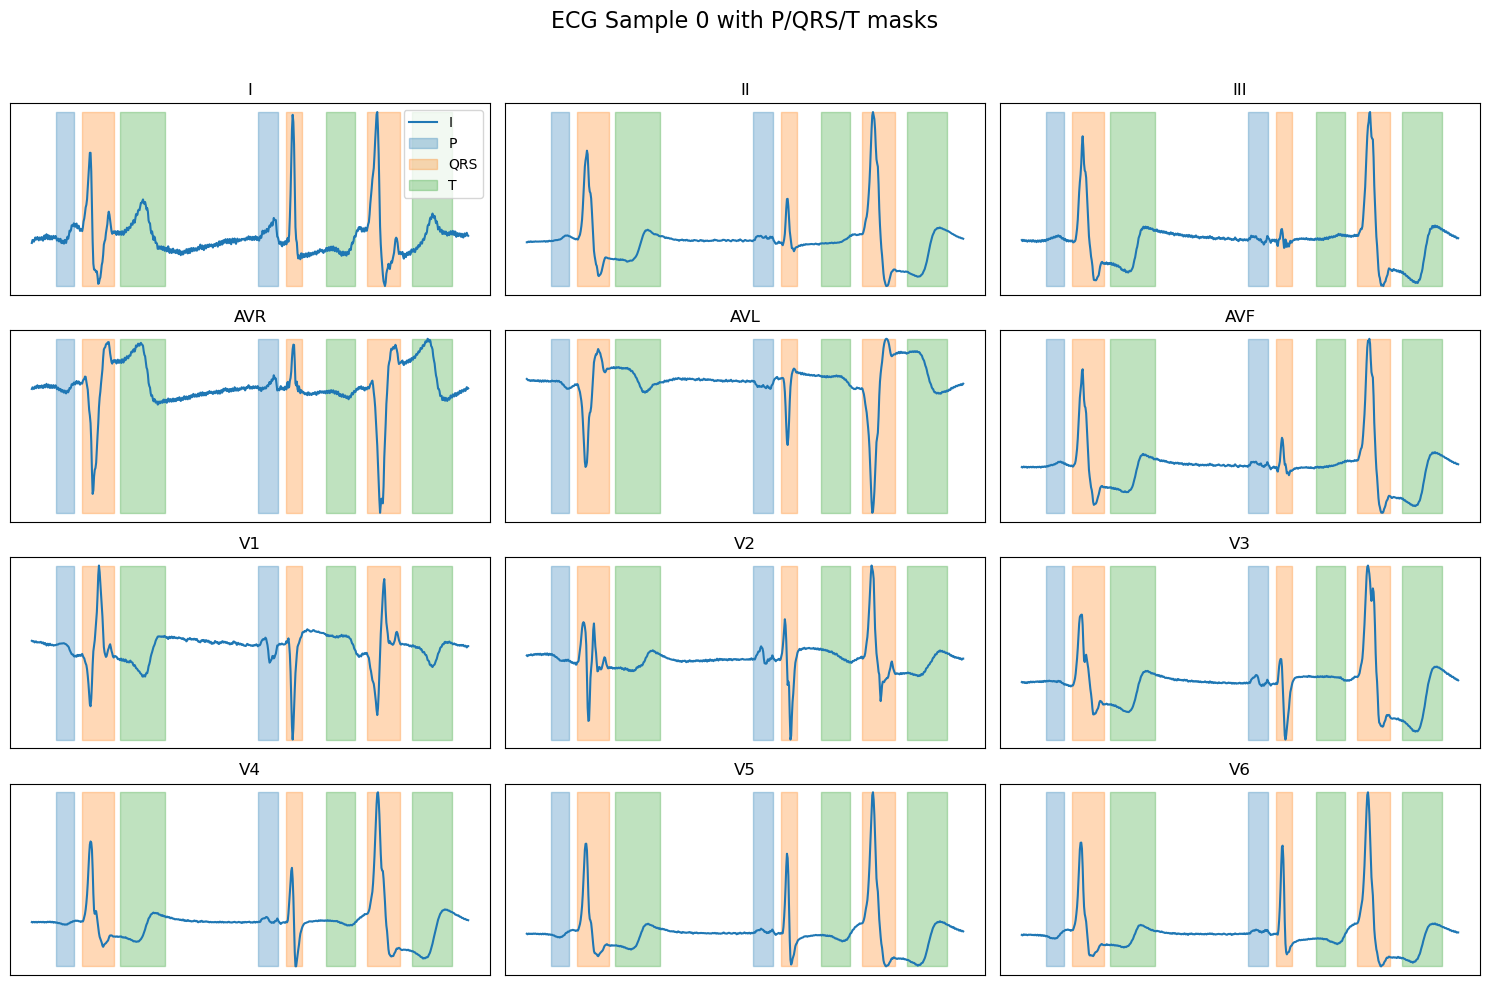

In [13]:
import matplotlib.pyplot as plt
import numpy as np
from sak.signal import StandardHeader

# Choose one sample (already shape [625, 12])
sample_index = 0
signal = ecg_signals_all[sample_index]

# Predict masks per lead (example: using V1 only for segmentation to get a common mask)
mask = predict_ecg(signal[:, 6][:, np.newaxis], model=models)  # Use V1 (lead 6) as representative
segmentation = mask  # shape (3, N)

# Build x-axis (assuming fs = 250 and 2.5 seconds of signal)
fs = 250
x = np.linspace(0, 2.5, signal.shape[0])

# Plot all 12 leads in a 4x3 grid
fig, ax = plt.subplots(4, 3, figsize=(15, 10))
fig.suptitle(f"ECG Sample {sample_index} with P/QRS/T masks", fontsize=16)

for i in range(12):
    row, col = divmod(i, 3)
    lead_signal = signal[:, i]

    ax[row, col].plot(x, lead_signal, label=StandardHeader[i])
    ax[row, col].fill_between(x, np.min(lead_signal), np.max(lead_signal),
                              where=(segmentation[0, :] == 1), color='C0', alpha=0.3, label='P')
    ax[row, col].fill_between(x, np.min(lead_signal), np.max(lead_signal),
                              where=(segmentation[1, :] == 1), color='C1', alpha=0.3, label='QRS')
    ax[row, col].fill_between(x, np.min(lead_signal), np.max(lead_signal),
                              where=(segmentation[2, :] == 1), color='C2', alpha=0.3, label='T')
    ax[row, col].set_title(StandardHeader[i])
    ax[row, col].set_xticks([])
    ax[row, col].set_yticks([])

# Optional: add legend to one subplot only
ax[0, 0].legend(loc="upper right")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


### Step 5: Export Features 

In [14]:

from tqdm import tqdm

features_list = []

# Loop over all ECG samples
for i in tqdm(range(len(ecg_signals_all)), desc="Extracting features"):
    signal = ecg_signals_all[i]  # shape: (625, 12)
    feats_all_leads = {}

    try:
        # Loop over each lead (single-lead prediction and feature extraction)
        for j, lead_name in enumerate(["I", "II", "III", "AVR", "AVL", "AVF", "V1", "V2", "V3", "V4", "V5", "V6"]):
            lead = signal[:, j]  # shape: (N,)
            if lead.ndim != 1 or lead.shape[0] < 10:
                raise ValueError(f"Invalid lead shape: {lead.shape} for {lead_name}")
            lead = lead[:, np.newaxis]

            mask = predict_ecg(lead, model=models)

            # Safety check: ensure mask is 2D with 3 rows (P, QRS, T)
            if mask.shape[0] != 3 or mask.shape[1] != signal.shape[0]:
                raise ValueError(f"Invalid mask shape {mask.shape} for lead {lead_name}")

            feats = extract_morph_features(lead, mask)

            # Prefix feature names with lead
            for k, v in feats.items():
                feats_all_leads[f"{lead_name}_{k}"] = v

        # Track SampleID from the df_signals dataframe
        feats_all_leads["SampleID"] = df_signals.iloc[i]["SampleID"]
        features_list.append(feats_all_leads)

    except Exception as e:
        print(f"⚠️ Skipping sample {i} (SampleID={df_signals.iloc[i]['SampleID']}) due to error: {e}")

# Create final DataFrame and save
df_feats = pd.DataFrame(features_list)
df_feats.to_csv("all_features.csv", index=False)
print("✅ Saved all_features.csv with shape:", df_feats.shape)

Extracting features:   0%|          | 125/29153 [09:14<35:47:41,  4.44s/it]


KeyboardInterrupt: 